In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string
from keras.callbacks import ModelCheckpoint



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 

# Load the data
fileGlob = glob.glob('./task2Data/*A.arabic.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','label','raw']
#traindf = traindf.drop(['date'], axis=1)

In [3]:
def preprocess(tweet, stop_words):
    # Convert emojis to words
    tweet = emoji.demojize(tweet)
    # Handle utf8 unicode problems
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    #tweet = contractions.fix(tweet)
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word.lower() for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('arabic')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)


In [4]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

2678
['shihanh010', 'ø¨ù\x88ø´', 'ù\x88ø§ù\x84ø§', 'ø§ù\x88ø¨ø§ù', 'ø§', 'face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_wit

In [5]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 785620354970574848]

print(sample.raw)
print(sample.text)
print(sample.label)


1021    @shihanh010 بوش والا اوباما😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂
Name: raw, dtype: object
1021    [shihanh010, ø¨ùø´, ùø§ùø§, ø§ùø¨ø§ù, ø§, face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :

In [6]:
tweet = sample.raw.to_string()
tweet = emoji.demojize(tweet)
tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
tweetLine = word_tokenize(tweet)
print(tweetLine)

['1021', '@', 'shihanh010', 'Ø¨Ù\x88Ø´', 'Ù\x88Ø§Ù\x84Ø§', 'Ø§Ù\x88Ø¨Ø§Ù', 'Ø§', ':', 'face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_o

In [7]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1, }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [8]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 150 # Motivated because max sequence of words i had was 140, char limit is 140 so this should be max

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [9]:
# Split val and training data
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
print(y_val.value_counts())
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)

#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

neutral     368
negative    285
positive    186
Name: label, dtype: int64


In [10]:
# Create LSTM model 
VOCAB_SIZE = 30000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,080,703
Trainable params: 3,080,703
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Save the best weights to a file so we get the model with the best val acc
weightsFilePath="task2Weights.best.hdf5"
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val),callbacks=[checkpoint],verbose=1)

Train on 2516 samples, validate on 839 samples
Epoch 1/5
2516/2516 [==============================] - 5s 2ms/step - loss: 1.0757 - acc: 0.4304 - val_loss: 1.0517 - val_acc: 0.4374

Epoch 00001: val_acc improved from -inf to 0.43743, saving model to task2Weights.best.hdf5
Epoch 2/5
2516/2516 [==============================] - 4s 2ms/step - loss: 0.9865 - acc: 0.5223 - val_loss: 1.0179 - val_acc: 0.4744

Epoch 00002: val_acc improved from 0.43743 to 0.47437, saving model to task2Weights.best.hdf5
Epoch 3/5
2516/2516 [==============================] - 4s 2ms/step - loss: 0.6696 - acc: 0.7190 - val_loss: 1.0225 - val_acc: 0.5268

Epoch 00003: val_acc improved from 0.47437 to 0.52682, saving model to task2Weights.best.hdf5
Epoch 4/5
2516/2516 [==============================] - 4s 2ms/step - loss: 0.2409 - acc: 0.9455 - val_loss: 1.1971 - val_acc: 0.5471

Epoch 00004: val_acc improved from 0.52682 to 0.54708, saving model to task2Weights.best.hdf5
Epoch 5/5
2516/2516 [=======================

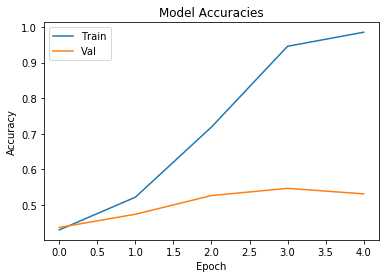

In [12]:
# Plot history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [13]:
# Notes on experimental architectures:
# With stop word removal, demojizing, string.punctuation word remova, vocab size 30000, padding at 50, get 0.56 val accuracy 
# decreasing vocab size to 5000 causes bad results and strange effects
# adding dropout layers made it worse by 2% therefore removed dropout layers

In [14]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)
y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [15]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [16]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    recalls = []
    precisions = []
    for i in range(noClasses):
        correct = cm[i][i]
        # if row or col total is zero set to 1 to avoid nans
        rowTotal = max(sum(cm[i]),1)
        colTotal = max(sum(cm[:,i]),1)
        recall = correct / rowTotal
        recalls.append(recall)
        precision = correct / colTotal
        precisions.append(precision)
        
        # Get denominator, if 0 set to 1 to avoid nans
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses, recalls, precisions

In [19]:
# Rows are the actual, columns are the predicted.  negative, neutral, positve
print(cm)
valAccuracy = (cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"valAccuracy {valAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[157 104  24]
 [ 69 225  74]
 [ 19  90  77]]
Average fscore: 0.5302790805652039
valAccuracy 0.5470798569725864
Recalls for each class: [0.5508771929824562, 0.6114130434782609, 0.41397849462365593]
Precisions for each class [0.6408163265306123, 0.5369928400954654, 0.44]


## Performance on Test Data


In [20]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.arabic.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','label','raw']

testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)



In [21]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())

# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

neutral     2364
negative    2222
positive    1514
Name: label, dtype: int64


In [22]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [23]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=['negative','neutral','positive'])

print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[ 775 1233  214]
 [ 371 1694  299]
 [ 198  929  387]]
Average fscore: 0.43332829277231094
testAccuracy 0.4681967213114754
Recalls for each class: [0.3487848784878488, 0.7165820642978004, 0.25561426684280053]
Precisions for each class [0.5766369047619048, 0.43931535269709543, 0.43]


Confusion matrix shows prediction in columns of negative, neutral and positive. Groundtruth are in rows of negative, neutral and positive. 
Test accuracy is 46.8%. We can see from the confusion matrix that the classifier particularly struggles to classify when the text is neutral, its recall of positive samples is 25.5%. Therefore to help improve this model we could try concentrating on features that help to classify positive text. The fact that the model is worse than guessing when the data is positive is concerning and suggests there is a lot of room for improvement. We would expect that the neutral class is the hardest to classify though as it's most similar to the two other classes. Both the training and test data have a class imbalance. Future work could try addressing this class imbalance. I think large difference between the neutral and the positive recalls shows the model struggles to distiguish between them and has placed its decision boundary to get more of the neutral cases right. The positive class si the smallest in both the test and the training data, which may explain why the model has done this. If we wanted to identify neutral tweets then this model would be very useful but most applications would want to classify the negative or the positive tweets, so the future work may want to incentivise the model to improve recall on negative and positive classes, either by balancing the data or creating a custom loss function. 